In [16]:
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.interval.laplacian_inverse_operator import LaplacianInverseOperator
import numpy as np
import matplotlib.pyplot as plt


In [17]:
interval = IntervalDomain(0, 1)
bcs = BoundaryConditions('dirichlet', left=0, right=0)
M = L2Space(10, interval)
covariance = LaplacianInverseOperator(M, bcs, solver_type='native')
M.create_gaussian_measure('kl', kl_expansion=1000, covariance=covariance)

LaplacianInverseOperator initialized with native solver, dirichlet(left=0, right=0) BCs


<Axes: title={'center': 'Function on [0.0, 1.0]'}, xlabel='x', ylabel='f(x)'>

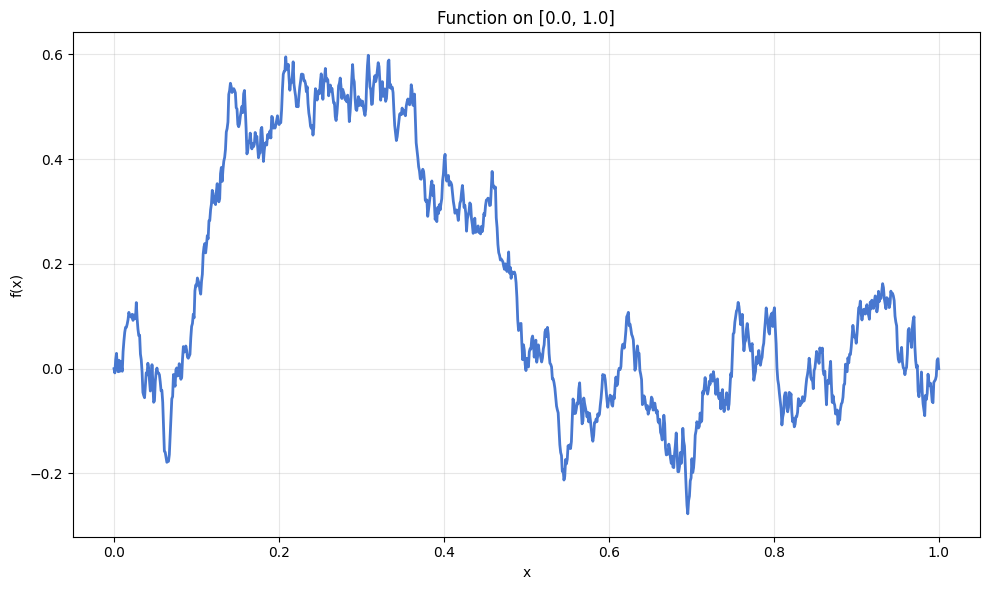

In [18]:
M.gaussian_measure.sample().plot()

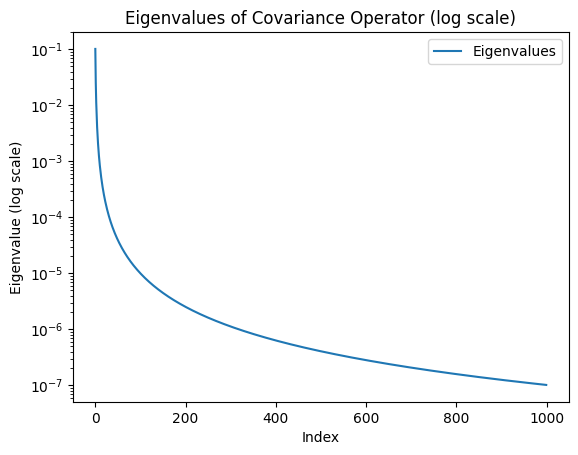

In [20]:
eigenvalues = covariance.get_all_eigenvalues(n=1000)  # Example usage to get eigenvalues
plt.semilogy(eigenvalues, label='Eigenvalues')
plt.xlabel('Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalues of Covariance Operator (log scale)')
plt.legend()
plt.show()